In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import gc

In [2]:
# Define data transforms
transform = transforms.Compose([
    transforms.RandomCrop(256, padding=32, padding_mode='reflect'), 
    transforms.ToTensor(),
    transforms.Normalize((0.4722, 0.4815, 0.4019),(0.2427, 0.2408, 0.2654))
])


transform_val = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.4722, 0.4815, 0.4019),(0.2427, 0.2408, 0.2654))
])

# Define paths to your data directories
train_data_dir = '/kaggle/input/birds25/Birds_25/train'
val_data_dir = '/kaggle/input/birds25/Birds_25/val'

# Create datasets
train_dataset = ImageFolder(root=train_data_dir, transform=transform)
val_dataset = ImageFolder(root=val_data_dir, transform=transform_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Labels: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna', 'Common-Rosefinch', 'Common-Tailorbird', 'Coppersmith-Barbet', 'Forest-Wagtail', 'Gray-Wagtail', 'Hoopoe', 'House-Crow', 'Indian-Grey-Hornbill', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Roller', 'Jungle-Babbler', 'Northern-Lapwing', 'Red-Wattled-Lapwing', 'Ruddy-Shelduck', 'Rufous-Treepie', 'Sarus-Crane', 'White-Breasted-Kingfisher', 'White-Breasted-Waterhen', 'White-Wagtail']
tensor([ 6,  2,  0, 15, 18, 24, 16, 11, 17, 23, 22, 24, 13, 20,  9, 20, 11, 11,
        12, 21,  0, 24, 15, 12,  5,  5,  1, 12, 22,  2, 15, 20])
torch.Size([32, 3, 256, 256]) torch.Size([32])


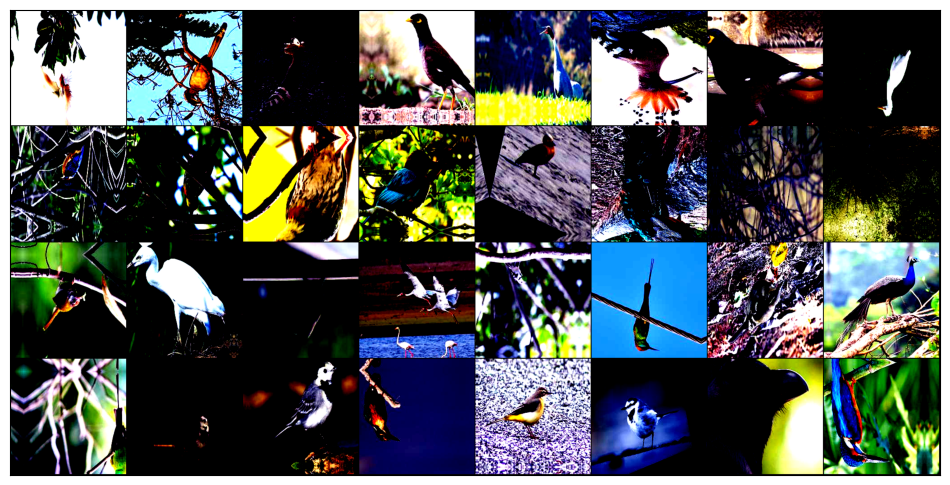

In [3]:
# Accessing labels:
print("Labels:", train_dataset.classes)

examples = iter(val_loader)
samples, labels = next(examples)
print(labels)
print(samples.shape, labels.shape)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(train_loader)

In [4]:
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Accessing labels:
print("Labels:", train_dataset.classes)

examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(train_loader)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classes =  ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna', 'Common-Rosefinch', 'Common-Tailorbird', 'Coppersmith-Barbet', 'Forest-Wagtail', 'Gray-Wagtail', 'Hoopoe', 'House-Crow', 'Indian-Grey-Hornbill', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Roller', 'Jungle-Babbler', 'Northern-Lapwing', 'Red-Wattled-Lapwing', 'Ruddy-Shelduck', 'Rufous-Treepie', 'Sarus-Crane', 'White-Breasted-Kingfisher', 'White-Breasted-Waterhen', 'White-Wagtail']

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.downsample:
            x = self.downsample(x)
        identity = x
            
        out = self.relu(self.batch1(self.conv1(x)))
        out = self.batch2(self.conv2(out))
        
        out += identity
        out = self.relu(out)
        return out

In [36]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=25):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1])
        self.layer3 = self._make_layer(block, 64, layers[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=3, stride=2,padding=1),
                nn.BatchNorm2d(planes)
            )

        layers = []
        self.inplanes = planes
        layers.append(block(self.inplanes, planes,1, downsample))
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
       
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1) 
        x = self.fc(x)

        return x

In [37]:
num_layers = 2
num_classes = 25
num_epochs = 50
learning_rate = 0.0001
model = ResNet(ResBlock, [num_layers, num_layers, num_layers]).to(device)

In [38]:
# model.load_state_dict(torch.load('/kaggle/input/my-model50/my_model50.pth'))

In [39]:
criterion = nn.CrossEntropyLoss()
total_step = len(train_loader)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=0.0001)
            
# torch.save(model.state_dict(), '/kaggle/working/my_model.pth')

In [41]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

        if (i+1)%50 == 0:
            print('epoch {}/{}, step {}/{}, loss = {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
torch.save(model.state_dict(), '/kaggle/working/my_model.pth')

epoch 1/50, step 50/920, loss = 2.9407
epoch 1/50, step 100/920, loss = 3.1034
epoch 1/50, step 150/920, loss = 2.9890
epoch 1/50, step 200/920, loss = 2.7502
epoch 1/50, step 250/920, loss = 2.7317
epoch 1/50, step 300/920, loss = 2.7214
epoch 1/50, step 350/920, loss = 2.6876
epoch 1/50, step 400/920, loss = 2.6361
epoch 1/50, step 450/920, loss = 2.6270
epoch 1/50, step 500/920, loss = 2.6719
epoch 1/50, step 550/920, loss = 2.7446
epoch 1/50, step 600/920, loss = 2.9023
epoch 1/50, step 650/920, loss = 2.5934
epoch 1/50, step 700/920, loss = 2.6262
epoch 1/50, step 750/920, loss = 2.7645
epoch 1/50, step 800/920, loss = 2.6562
epoch 1/50, step 850/920, loss = 2.5910
epoch 1/50, step 900/920, loss = 2.5723
epoch 2/50, step 50/920, loss = 2.6218
epoch 2/50, step 100/920, loss = 2.2262
epoch 2/50, step 150/920, loss = 2.4432
epoch 2/50, step 200/920, loss = 2.5147
epoch 2/50, step 250/920, loss = 2.2125
epoch 2/50, step 300/920, loss = 2.5406
epoch 2/50, step 350/920, loss = 2.4408
ep

In [42]:
torch.save(model.state_dict(), '/kaggle/working/my_model.pth')

In [43]:
#validate
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for _ in range(25)]
    n_class_samples = [0 for _ in range(25)]
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predicted == labels).sum().item()
        m = labels.shape[0]
        for i in range(m):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        del images,labels,outputs

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network for val: {acc} %')

    for i in range(25):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of for val {classes[i]}: {acc} %')

Accuracy of the network for val: 80.66088196838227 %
Accuracy of for val Asian-Green-Bee-Eater: 88.64353312302839 %
Accuracy of for val Brown-Headed-Barbet: 54.44444444444444 %
Accuracy of for val Cattle-Egret: 88.9589905362776 %
Accuracy of for val Common-Kingfisher: 91.07692307692308 %
Accuracy of for val Common-Myna: 76.10619469026548 %
Accuracy of for val Common-Rosefinch: 64.92307692307692 %
Accuracy of for val Common-Tailorbird: 68.8622754491018 %
Accuracy of for val Coppersmith-Barbet: 83.09037900874635 %
Accuracy of for val Forest-Wagtail: 82.24299065420561 %
Accuracy of for val Gray-Wagtail: 81.65137614678899 %
Accuracy of for val Hoopoe: 85.5072463768116 %
Accuracy of for val House-Crow: 79.21348314606742 %
Accuracy of for val Indian-Grey-Hornbill: 66.46706586826348 %
Accuracy of for val Indian-Peacock: 87.53799392097264 %
Accuracy of for val Indian-Pitta: 86.99421965317919 %
Accuracy of for val Indian-Roller: 80.24691358024691 %
Accuracy of for val Jungle-Babbler: 86.6468842

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/my_model.pth')

In [44]:
# Define paths to your data directories
test_data_dir = '/kaggle/input/birds25/Birds_25/test'

# Create datasets
test_dataset = ImageFolder(root=test_data_dir, transform=transform_val)

batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [45]:
#validate
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for _ in range(25)]
    n_class_samples = [0 for _ in range(25)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predicted == labels).sum().item()
        m = labels.shape[0]
        for i in range(m):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        del images,labels,outputs

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network for val: {acc} %')

    for i in range(25):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of for val {classes[i]}: {acc} %')

Accuracy of the network for val: 77.81333333333333 %
Accuracy of for val Asian-Green-Bee-Eater: 87.66666666666667 %
Accuracy of for val Brown-Headed-Barbet: 54.0 %
Accuracy of for val Cattle-Egret: 81.66666666666667 %
Accuracy of for val Common-Kingfisher: 86.33333333333333 %
Accuracy of for val Common-Myna: 72.0 %
Accuracy of for val Common-Rosefinch: 64.33333333333333 %
Accuracy of for val Common-Tailorbird: 58.666666666666664 %
Accuracy of for val Coppersmith-Barbet: 88.33333333333333 %
Accuracy of for val Forest-Wagtail: 78.66666666666667 %
Accuracy of for val Gray-Wagtail: 77.66666666666667 %
Accuracy of for val Hoopoe: 83.33333333333333 %
Accuracy of for val House-Crow: 78.66666666666667 %
Accuracy of for val Indian-Grey-Hornbill: 65.0 %
Accuracy of for val Indian-Peacock: 81.33333333333333 %
Accuracy of for val Indian-Pitta: 86.0 %
Accuracy of for val Indian-Roller: 76.33333333333333 %
Accuracy of for val Jungle-Babbler: 82.0 %
Accuracy of for val Northern-Lapwing: 80.6666666666